In [1]:
import logging, tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

import copy
import time, yaml, glob
from collections import defaultdict, OrderedDict

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cartopy import crs as ccrs
from cartopy import feature as cfeature

from reliability import reliability_diagram, reliability_diagrams, compute_calibration
from plotting import plot_confusion_matrix
from losses import *
from seed import torch_seed_everything
from metrics import *

/glade/work/jwillson/conda-envs/winter-ptype/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-20 09:22:16.164132: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Model Evaluation

### Load Saved Model

In [2]:
dataset = 'ASOS'

In [3]:
config = f'evidential_config/asos072022_pl10fzra2.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
    
# model config
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
upsampling = conf['upsampling']
test_path = f"{conf['test_path']}{upsampling}.pt"
model_name = f"{conf['model_name']}{upsampling}"
image_path = conf['image_path'] + f'{model_name}/'

seed = conf['trainer']['seed']
epochs = conf['trainer']['epochs']
num_hidden_layers = conf['trainer']['num_hidden_layers']
hidden_size = conf['trainer']['hidden_size']
dropout_rate = conf['trainer']['dropout_rate']
batch_size = conf['trainer']['batch_size']
learning_rate = conf['trainer']['learning_rate']
activation = conf['trainer']['activation']
criterion = conf['trainer']['criterion']
metrics = conf['trainer']['metrics']

# set seed
torch_seed_everything(seed)

test_split = torch.load(test_path)
test_loader = DataLoader(test_split, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=0)

def load_mlp_model(input_size, hidden_size, output_size, num_hidden_layers, dropout_rate, activation):
    activation_dict = {'leaky':nn.LeakyReLU(), 'elu':nn.ELU(), 'relu':nn.ReLU() , 'selu':nn.SELU()}
    activation_fn = activation_dict[activation]

    model = nn.Sequential()
    model.append(nn.utils.spectral_norm(nn.Linear(input_size, hidden_size)))
    model.append(activation_fn)

    for i in range(num_hidden_layers):
        if num_hidden_layers == 1:
            model.append(nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)))
            model.append(activation_fn)
        else:
            model.append(nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)))
            model.append(activation_fn)
            model.append(nn.Dropout(dropout_rate))

    model.append(nn.utils.spectral_norm(nn.Linear(hidden_size, output_size)))
    print(model)

    return model

model = load_mlp_model(len(features), hidden_size, len(outputs), num_hidden_layers, dropout_rate, activation)
model.load_state_dict(torch.load(f'/glade/work/jwillson/{model_name}.pt'))

Sequential(
  (0): Linear(in_features=268, out_features=936, bias=True)
  (1): SELU()
  (2): Linear(in_features=936, out_features=936, bias=True)
  (3): SELU()
  (4): Dropout(p=0.30613678635162145, inplace=False)
  (5): Linear(in_features=936, out_features=936, bias=True)
  (6): SELU()
  (7): Dropout(p=0.30613678635162145, inplace=False)
  (8): Linear(in_features=936, out_features=936, bias=True)
  (9): SELU()
  (10): Dropout(p=0.30613678635162145, inplace=False)
  (11): Linear(in_features=936, out_features=936, bias=True)
  (12): SELU()
  (13): Dropout(p=0.30613678635162145, inplace=False)
  (14): Linear(in_features=936, out_features=936, bias=True)
  (15): SELU()
  (16): Dropout(p=0.30613678635162145, inplace=False)
  (17): Linear(in_features=936, out_features=936, bias=True)
  (18): SELU()
  (19): Dropout(p=0.30613678635162145, inplace=False)
  (20): Linear(in_features=936, out_features=936, bias=True)
  (21): SELU()
  (22): Dropout(p=0.30613678635162145, inplace=False)
  (23): Line

<All keys matched successfully>

### Test Model

In [4]:
def test_model(
    test_loader,
    metrics=["acc"],
    num_classes=4,
    device=None,
    verbose=True,
    use_uncertainty=True
):
    metric_dict = {'torch_acc':torch_acc, 'torch_average_acc':torch_average_acc, 
                      'torch_ece':torch_ece, 'torch_balanced_ece':torch_balanced_ece}
    metric_fns = [metric_dict[metric] for metric in metrics]
    
    if not device:
        device = get_device()
    
    model.to(device)
    
    model.eval()
    with torch.no_grad():

        if verbose:
            total = int(np.ceil(len(test_loader.dataset) / batch_size))
            my_iter = tqdm.tqdm(enumerate(test_loader),
                            total = total,
                            leave = True)
        else:
            my_iter = enumerate(test_loader)
        
        # Iterate over data.
        results_dict = defaultdict(list)
        for i, (inputs, labels) in my_iter:

            inputs = inputs.to(device)
            labels = labels.to(device)

            if use_uncertainty:
                output = model(inputs)
                evidence = relu_evidence(output)
                alpha = evidence + 1
                uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
                _, preds = torch.max(output, 1)
                probs = alpha / torch.sum(alpha, dim=1, keepdim=True)
                results_dict["pred_uncertainty"].append(uncertainty)

            else:
                output = model(img_variable)
                _, preds = torch.max(output, 1)
                probs = F.softmax(output, dim=1)

            results_dict["pred_labels"].append(preds.unsqueeze(-1))
            results_dict["true_labels"].append(labels.unsqueeze(-1))
            results_dict["pred_probs"].append(probs)

            # statistics
            for i, metric in enumerate(metrics):
                if 'ece' in metric:
                    metric_value = metric_fns[i](labels, probs)
                else:
                    metric_value = metric_fns[i](labels, preds)
                results_dict[f"{metric}"].append(metric_value)

            if verbose:
                print_str = ''
                for metric in metrics:
                    print_str += f'test_{metric}: {np.mean(results_dict[f"{metric}"]):.4f} '
                my_iter.set_description(print_str)
                my_iter.refresh()

        results_dict["pred_uncertainty"] = torch.cat(results_dict["pred_uncertainty"], 0)
        results_dict["pred_probs"] = torch.cat(results_dict["pred_probs"], 0)
        results_dict["pred_labels"] = torch.cat(results_dict["pred_labels"], 0)
        results_dict["true_labels"] = torch.cat(results_dict["true_labels"], 0)
    
        return results_dict

metrics.append("torch_acc")  
results_dict = test_model(test_loader, metrics=metrics)

test_torch_average_acc: 0.7215 test_torch_acc: 0.9127 : 100%|██████████| 439/439 [00:05<00:00, 77.08it/s]


## Visualize Model Results

### Convert Torch Tensors to NumPy 

In [6]:
uncertainties = results_dict["pred_uncertainty"][:, 0].cpu().numpy()
preds = results_dict["pred_labels"][:, 0].cpu().numpy()
labels = results_dict["true_labels"][:, 0].cpu().numpy()
probs = np.max(results_dict["pred_probs"].cpu().numpy(), 1)

### Confusion Matrices

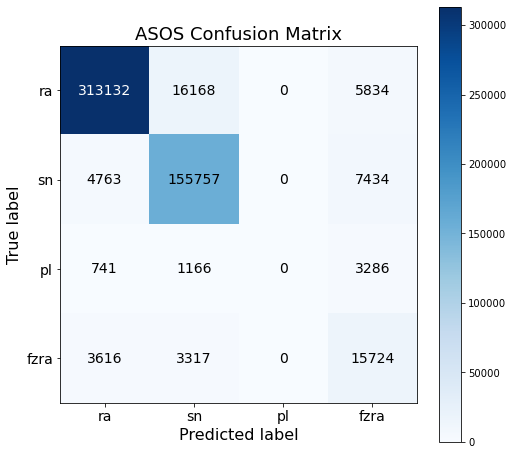

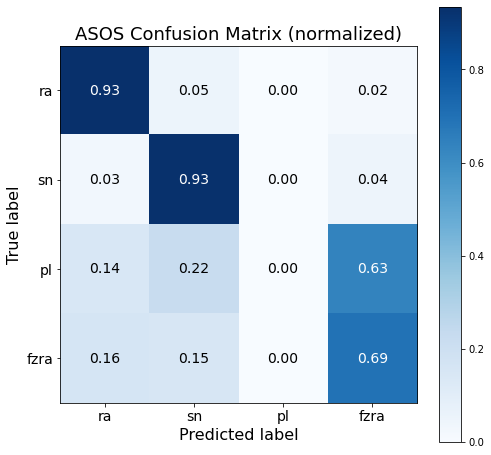

In [7]:
np.set_printoptions(precision=2)
class_names = ['ra', 'sn', 'pl', 'fzra']

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, class_names, model_name,
                      title=f'{dataset} Confusion Matrix', filename='cm.png')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, class_names, model_name, normalize=True,
                      title=f'{dataset} Confusion Matrix (normalized)', filename='cm_norm.png')

plt.show()

### Reliability Diagrams

In [8]:
test_data = pd.DataFrame.from_dict(
        {"pred_labels": preds,
    "true_labels": labels, 
    "pred_conf": probs,
    "uncertainty": uncertainties})

/glade/u/home/jwillson/winter-ptype/code/reliability.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


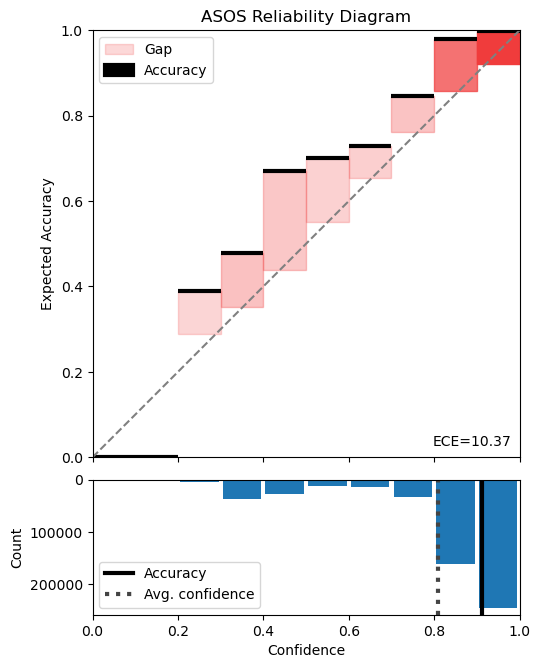

In [9]:
title = f"{dataset} Reliability Diagram"
fig = reliability_diagram(
    test_data["true_labels"].to_numpy(),
    test_data["pred_labels"].to_numpy(),
    test_data["pred_conf"].to_numpy(),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100,
    return_fig=True)

plt.savefig(f"{image_path}reliability.png", dpi=300, bbox_inches='tight')
plt.show()

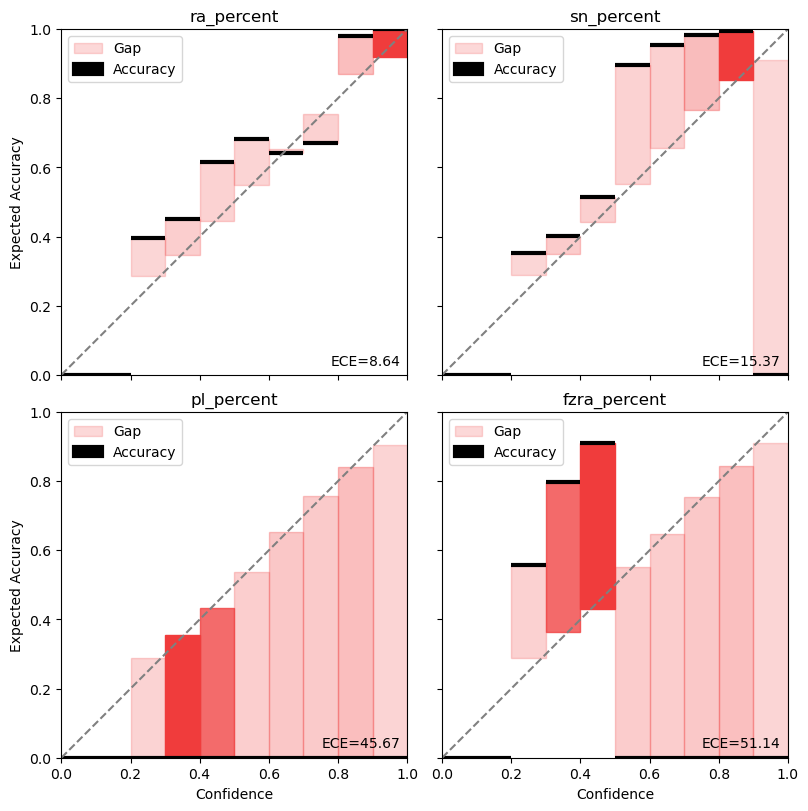

In [10]:
cond0 = (test_data["true_labels"] == 0)
cond1 = (test_data["true_labels"] == 1)
cond2 = (test_data["true_labels"] == 2)
cond3 = (test_data["true_labels"] == 3)
results = OrderedDict()
results[outputs[0]] = {
    "true_labels": test_data[cond0]["true_labels"].values,
    "pred_labels": test_data[cond0]["pred_labels"].values,
    "confidences": test_data[cond0]["pred_conf"].values
}
results[outputs[1]] = {
    "true_labels": test_data[cond1]["true_labels"].values,
    "pred_labels": test_data[cond1]["pred_labels"].values,
    "confidences": test_data[cond1]["pred_conf"].values
}
results[outputs[2]] = {
    "true_labels": test_data[cond2]["true_labels"].values,
    "pred_labels": test_data[cond2]["pred_labels"].values,
    "confidences": test_data[cond2]["pred_conf"].values
}
results[outputs[3]] = {
    "true_labels": test_data[cond3]["true_labels"].values,
    "pred_labels": test_data[cond3]["pred_labels"].values,
    "confidences": test_data[cond3]["pred_conf"].values
}
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha", num_cols=2, dpi=100, return_fig=True)
plt.savefig(f'{image_path}class_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

### Cumulative Accuracy Trends

/glade/scratch/jwillson/ipykernel_106848/2079708740.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])


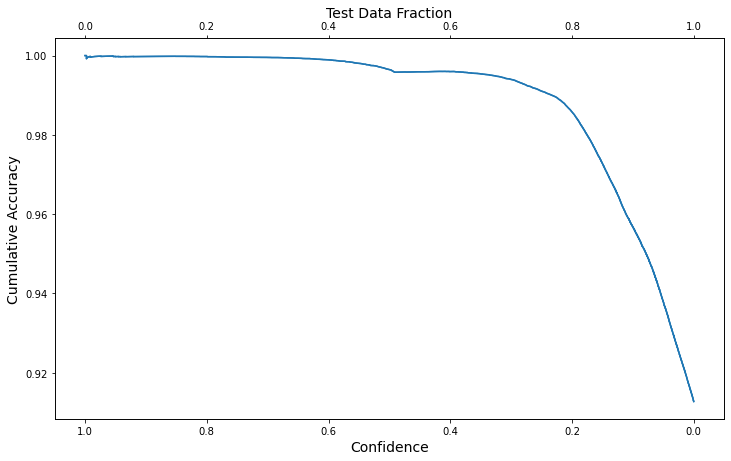

In [11]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])

ax2 = ax.twiny()
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax2.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)

plt.savefig(f'{image_path}acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

/glade/scratch/jwillson/ipykernel_106848/1240930782.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])


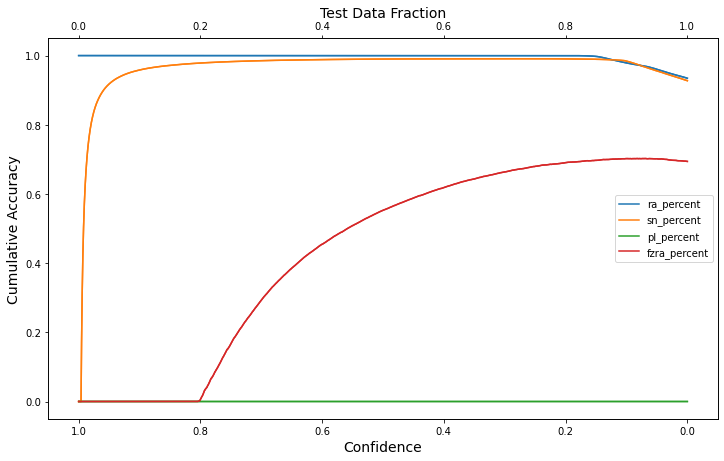

In [12]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twiny()
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )
    ax2.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )

ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)
ax.legend(outputs)
plt.savefig(f'{image_path}class_acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

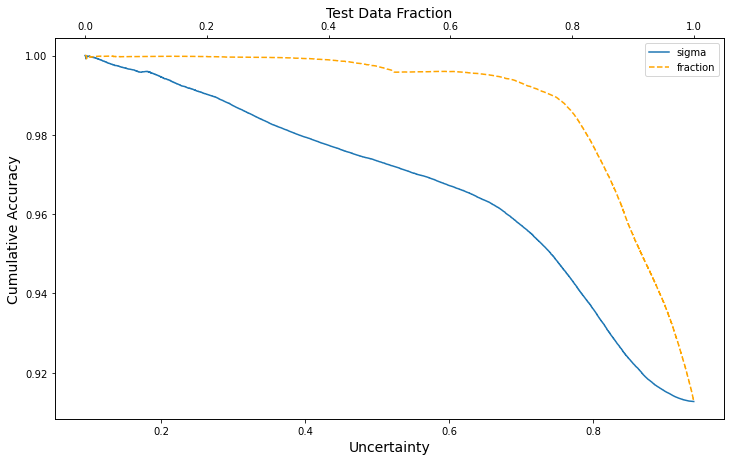

In [13]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)

test_data_sorted = compute_cov(test_data, col = "uncertainty", quan = "acc", ascending = True)

l1, = ax.plot(
    test_data_sorted["uncertainty"],
    test_data_sorted["cu_acc"],
    label = "sigma"
)

ax2 = ax.twiny()
l2, = ax2.plot(
    test_data_sorted["uncertainty_cov"],
    test_data_sorted["cu_acc"], 
    color='orange', ls = "--", 
    label = "fraction")

ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Uncertainty", fontsize=14)

plt.legend([l1, l2], ["sigma", "fraction"])
plt.savefig(f'{image_path}acc_vs_unc.png', dpi=300, bbox_inches='tight')
plt.show()

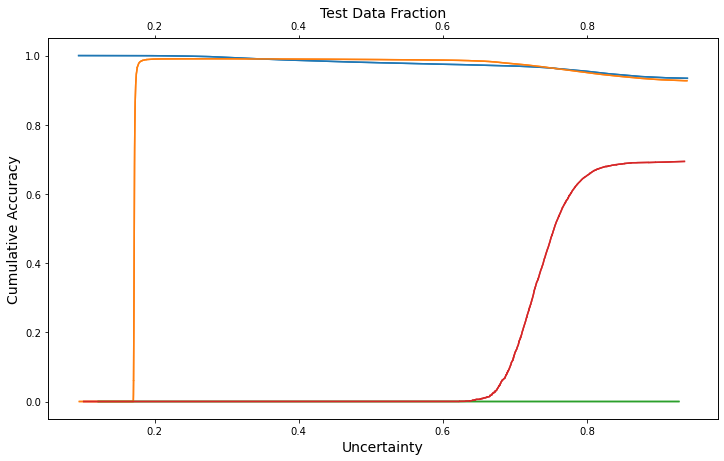

In [14]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twiny()
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax.plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    ax2.plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Uncertainty", fontsize=14)
plt.savefig(f'{image_path}class_acc_vs_unc.png', dpi=300, bbox_inches='tight')
plt.show()

## Case Studies

In [15]:
timeframe = 'feb2021'
upsampling = 'none'
scale = 0.15

In [16]:
df = pd.read_parquet(f"/glade/work/jwillson/{timeframe}.parquet")
test_split = torch.load(f"/glade/work/jwillson/{timeframe}_{upsampling}.pt")

test_loader = DataLoader(test_split, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=0)

results_dict = test_model(test_loader, metrics=metrics)

test_torch_average_acc: 0.6861 test_torch_acc: 0.9051 : 100%|██████████| 37/37 [00:00<00:00, 62.04it/s]


In [17]:
uncertainties = results_dict["pred_uncertainty"][:, 0].cpu().numpy()
preds = results_dict["pred_labels"][:, 0].cpu().numpy()
labels = results_dict["true_labels"][:, 0].cpu().numpy()
probs = np.max(results_dict["pred_probs"].cpu().numpy(), 1)

df["pred_label"] = preds
df["true_label"] = labels 
df["pred_conf"] = probs
df["uncertainty"] = uncertainties

In [18]:
latN = 54.0
latS = 20.0
lonW = -63.0
lonE = -125.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}

/glade/scratch/jwillson/ipykernel_106848/3347581302.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=20, markerscale=10, loc="lower right")


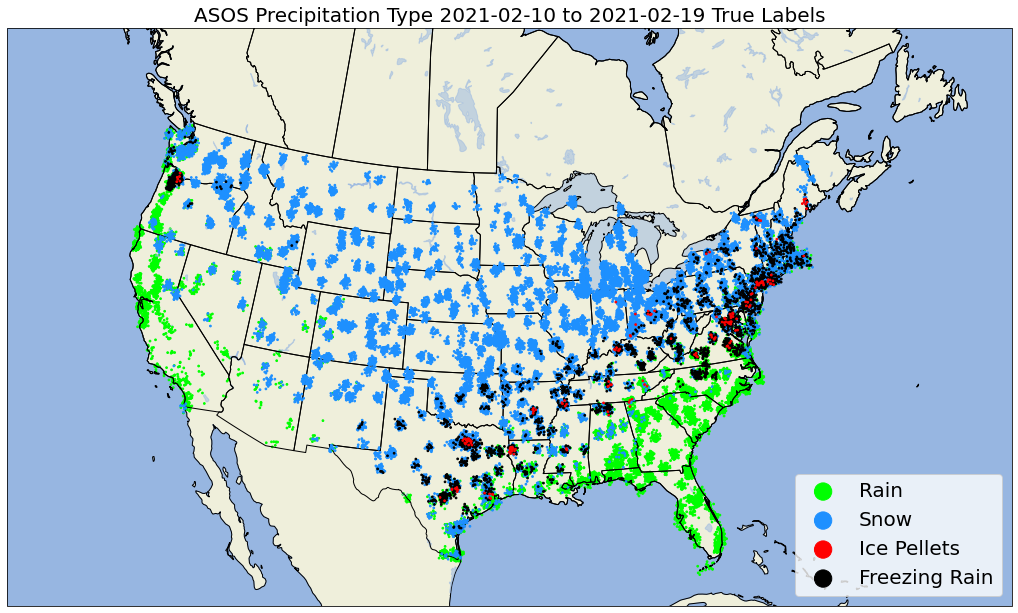

In [19]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
zorder = [1,2,4,3]

for i in range(4):
    ax.scatter(df["rand_lon"][df["true_label"] == i]-360,
               df["rand_lat"][df["true_label"] == i],
               c=df["true_label"][df["true_label"] == i].map(colors),
               s=3, transform=ccrs.PlateCarree(), zorder=zorder[i])

first_day = str(min(df['datetime'])).split(' ')[0]
last_day = str(max(df['datetime'])).split(' ')[0]
plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=20, markerscale=10, loc="lower right")
plt.title(f"{dataset} Precipitation Type {first_day} to {last_day} True Labels", fontsize=20)
# plt.savefig(f'{image_path}{timeframe}_truelabels.png', dpi=300, bbox_inches='tight')
plt.show()

/glade/scratch/jwillson/ipykernel_106848/3014523506.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=10, loc="lower right")


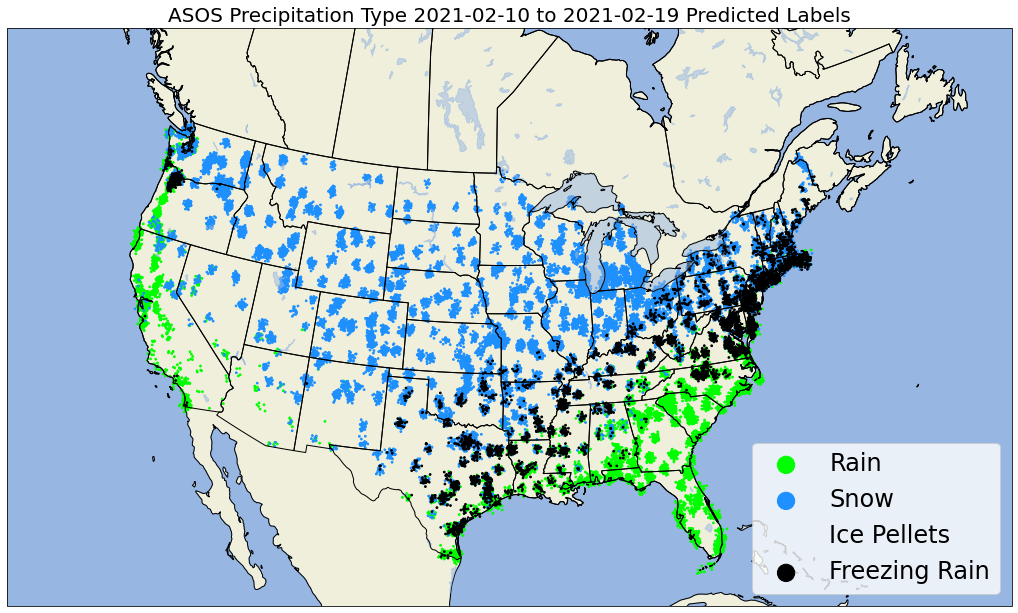

In [20]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
zorder = [1,2,4,3]

for i in range(4):
    ax.scatter(df["rand_lon"][df["pred_label"] == i]-360,
               df["rand_lat"][df["pred_label"] == i],
               c=df["pred_label"][df["pred_label"] == i].map(colors),
               s=3, transform=ccrs.PlateCarree())

first_day = str(min(df['datetime'])).split(' ')[0]
last_day = str(max(df['datetime'])).split(' ')[0]
plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=10, loc="lower right")
plt.title(f"{dataset} Precipitation Type {first_day} to {last_day} Predicted Labels", fontsize=20)
# plt.savefig(f'{image_path}{timeframe}_predlabels.png', dpi=300, bbox_inches='tight')
plt.show()

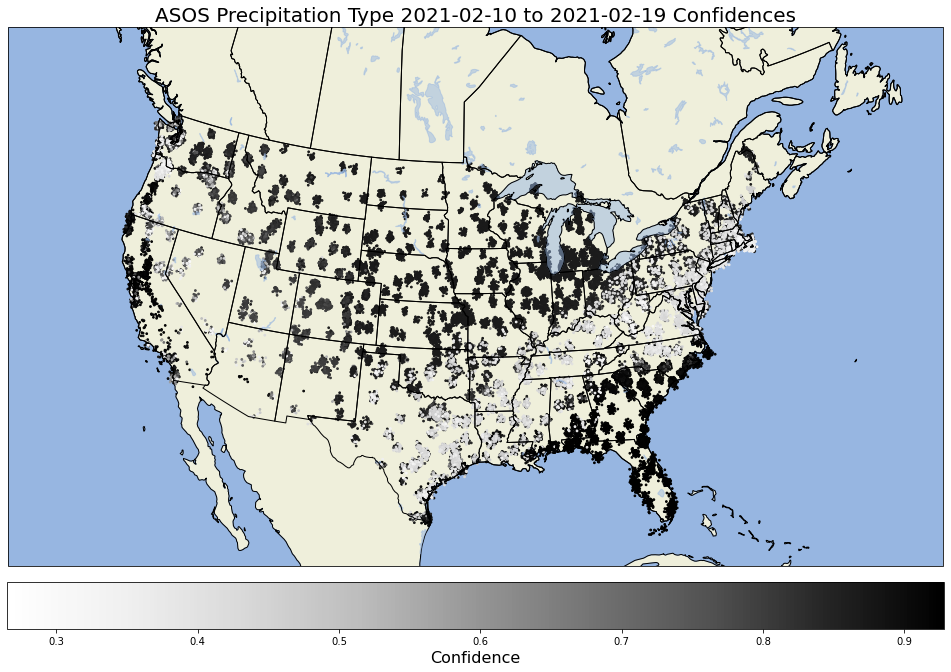

In [21]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
zorder = [1,2,4,3]

for i in range(4):
    sc = ax.scatter(df["rand_lon"][df["pred_label"] == i]-360,
               df["rand_lat"][df["pred_label"] == i],
               c=df["pred_conf"][df["pred_label"] == i],
               s=3, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df["pred_conf"].min(), vmax=df["pred_conf"].max())

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.025, shrink=0.9325)
cbar.set_label('Confidence',size=16)
plt.title(f"{dataset} Precipitation Type {first_day} to {last_day} Confidences", fontsize=20)
# plt.savefig(f'{image_path}{timeframe}_conf.png', dpi=300, bbox_inches='tight')
plt.show()

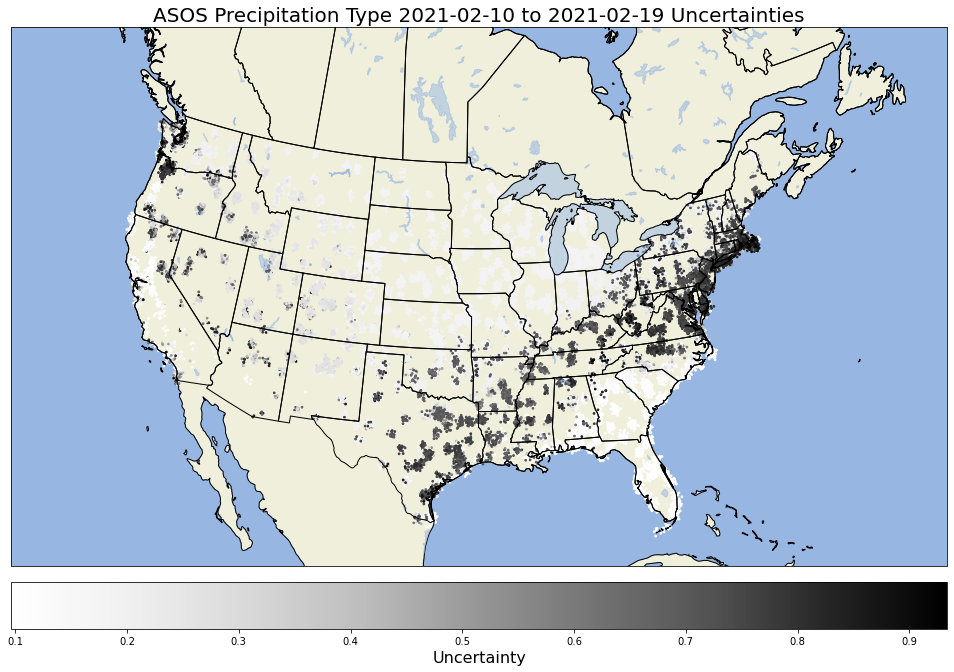

In [22]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
zorder = [1,2,4,3]

for i in range(4):
    sc = ax.scatter(df["rand_lon"][df["pred_label"] == i]-360,
               df["rand_lat"][df["pred_label"] == i],
               c=df["uncertainty"][df["pred_label"] == i],
               s=3, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df["uncertainty"].min(), vmax=df["uncertainty"].max())

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.025, shrink=0.9325)
cbar.set_label('Uncertainty',size=16)
plt.title(f"{dataset} Precipitation Type {first_day} to {last_day} Uncertainties", fontsize=20)
# plt.savefig(f'{image_path}{timeframe}_unc.png', dpi=300, bbox_inches='tight')
plt.show()